# ASHRAE - Great Energy Predictor III

### How much energy will a building consume?

#### Competition description

#### Q: How much does it cost to cool a skyscraper in the summer?

#### A: A lot! And not just in dollars, but in environmental impact.

#### ========================================================================================================

Thankfully, significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

#### ========================================================================================================

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

### Note: 
The competition is ongoing at the time of this posting and the rules prevent me from posting the solution before conclusion

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

HTML('<iframe width="1106" height="622" src="https://www.youtube.com/embed/2-G20qed5eg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [1]:
# libraries

import numpy as np 
import pandas as pd 
pd.set_option('max_columns', 150)

import os,random, math, psutil, pickle

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


# file location
#root = 'C:/Users/dmcul/KAGGLE_COMPETITIONS/ashrae-energy-prediction/'
root = 'C:/Users/v-docu/Downloads/ashrae-energy-prediction/'
print(os.listdir(root))

# Import the files
# train files
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
# test files
test_df = pd.read_csv(root + 'test.csv')
# weather train
weather_train_df = pd.read_csv(root + 'weather_train.csv')
# weather test
weather_test_df = pd.read_csv(root + 'weather_test.csv')
# building meta
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
# Sample submission
sample_submission = pd.read_csv(root + 'sample_submission.csv')

# Check the imports
print('Size of train_df data', train_df.shape)
print('Size of test_df data', test_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

# add row_id and change the column order
train_df['row_id'] = train_df.index
new_columns = ['row_id','building_id', 'meter', 'timestamp', 'meter_reading']
train_df = train_df[new_columns]


# official correction from BTU to kWh as of 11/27/2019
train_df['meter_reading'] = 0.2931 * train_df['meter_reading'] 
train_df[:3]

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'weather_train.csv']
Size of train_df data (20216100, 4)
Size of test_df data (41697600, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


,row_id,building_id,meter,timestamp,meter_reading
0,0,0,0,2016-01-01,0.0
1,1,1,0,2016-01-01,0.0
2,2,2,0,2016-01-01,0.0


# Memory reduction

We're dealing with over 20 mil rows in the training set and twice as many in the testing set. With sets this large, memory management becomes critical. We'll look at the ranges the dataset variables take and trim the default ranges of int and float to those ranges.

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # limits the extent of int8 range
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 366.31 Mb (52.5% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


# Visualize meter missing data

The training dataset represents a sample of 1449 buildings whose energy consumption is followed throughout the duration of 12 months. The energy readings come from four different meter types: meters for electricity, chilledwater, steam and hotwater. Not every building has all four meter types. We'll track each building in our training dataset on the y axis and the number of hours a meter has been providing readings since Jan 1 2016.

### Color legend:
#### Blue: zero value
#### Green: non-zero value
#### White: NaN

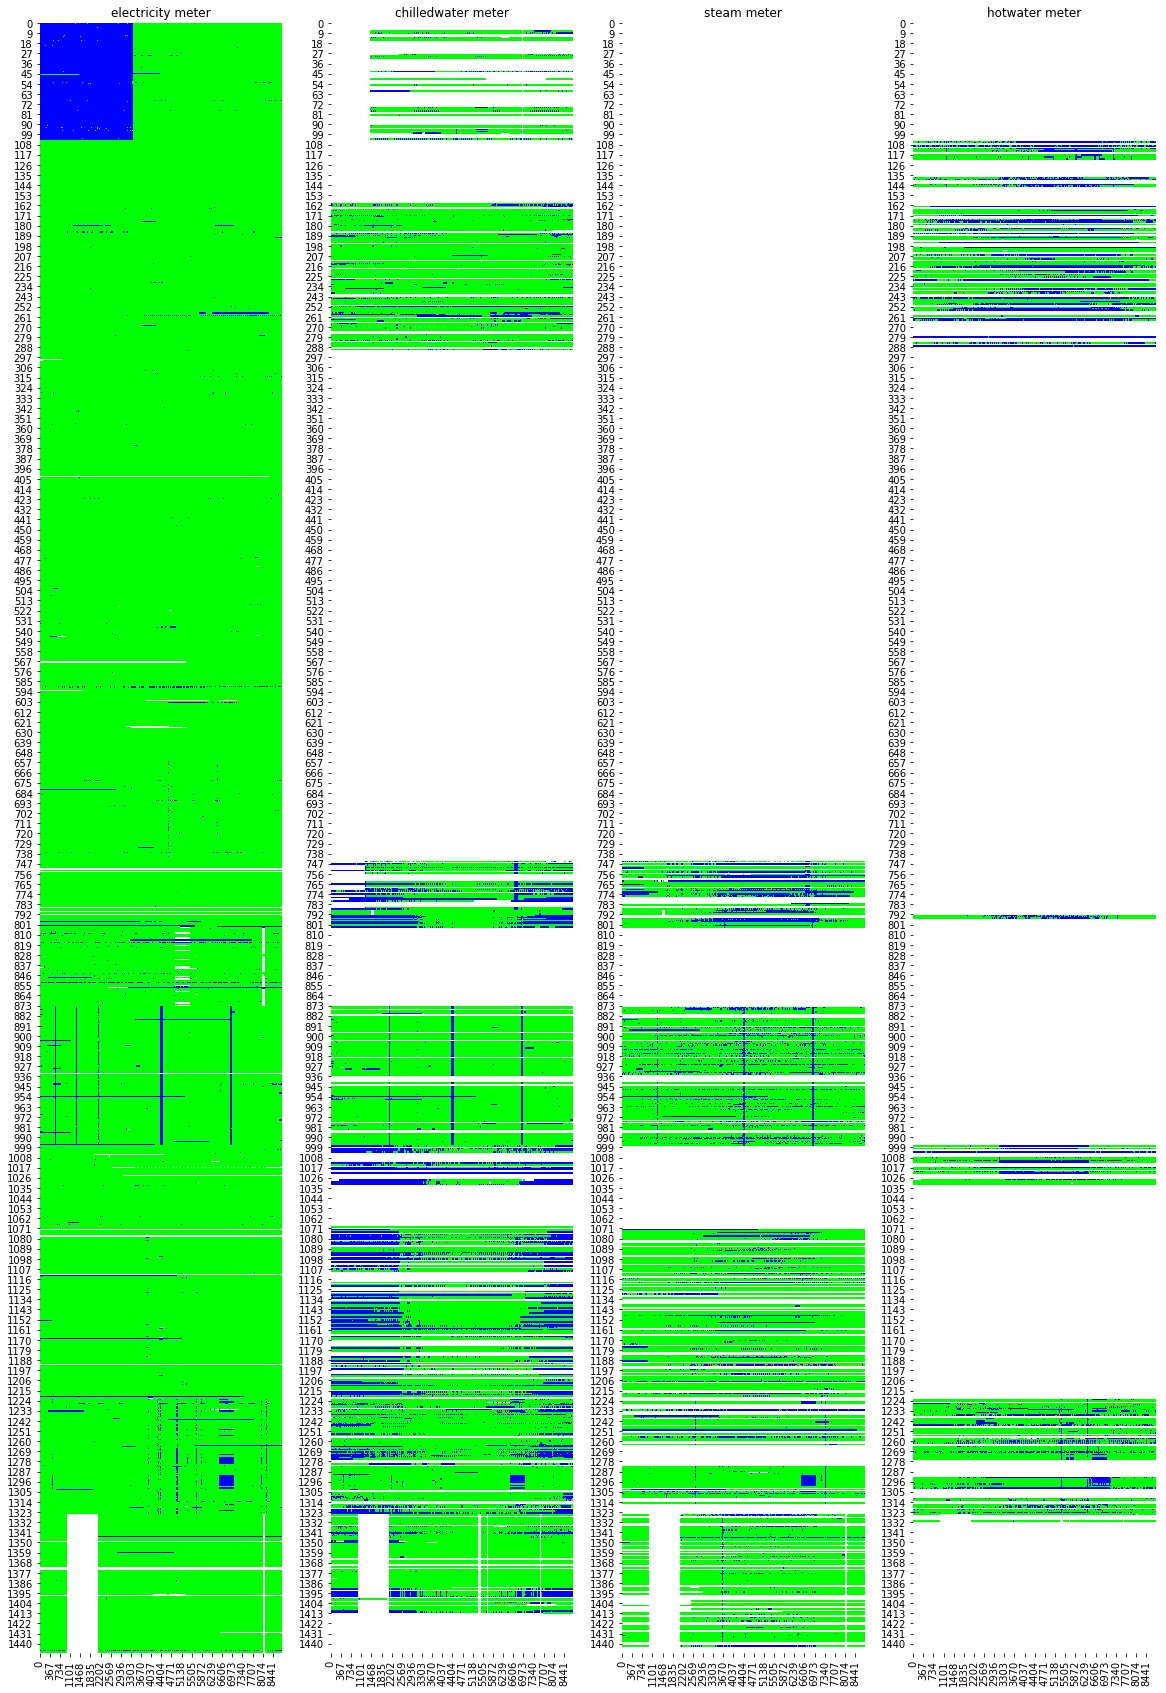

In [4]:
n_blds = len(np.unique(train_df['building_id'].values))
meter_type = ['electricity', 'chilledwater', 'steam', 'hotwater']

train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,len(np.unique(train_df.meter)),figsize=(20,30))
for meter in np.arange(len(np.unique(train_df.meter))):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((n_blds, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[3]!=meter:continue
        #print(int(l[1]))
        missmap[int(l[2]), int(l[0])] = 0 if l[4]==0 else 1 #Columns: [timestamp, building_id, meter, meter_reading]
    a[meter].set_title(f'{meter_type[meter]:s} meter')
    sns.heatmap(missmap, cmap='brg', ax=a[meter], cbar=False)

The vertical lines are suspicious. They reflect a temporay lack of data. For a reason or another, the meters didn't run during that time. This information can be used during filling the missing data phase

# Combining the data

Now it's time to combine the training, testing, weather and building metadata

In [3]:
# Join all dataset: train+weathe+site; test+weathe+site
train_df['timestamp'] = pd.to_datetime(train_df['timestamp']) # datetime
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
#print(train_df['timestamp'].dtype)

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
    
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)
#print(train_df['timestamp'].dtype) #datetime

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

# the order of columns IS VERY IMPORTANT. Let's sync column order between train and test dataframes
columns=[c for c in train_df.columns if c != 'meter_reading']
test_df=test_df[columns]

train_df.head(5)
train_df.shape

(20216100, 17)

# Training set trimming

Null or zero meter values offer no insight into usage patterns. We will remove these from the training set. Furthermore, to avoid situations where we have some readings but they are not at least for 12 consecutive hours, we'll remove those instances from out training set as well

In [4]:
train_df.head()

# remove the zero meter reading values from the training set
train_len = len(train_df)
print ("Initial Train Rows :",train_df.shape[0])
train_df['nonZero'] = (train_df.meter_reading>0).astype(int)

# impose a restriction on what is being carried over into the training set: only the readings with a lag of 12 hrs
lag = lambda x,l: x.shift(l).fillna(1)
mask = train_df.groupby(['building_id','meter'])['nonZero'].transform(lambda x: (x*lag(x,1)*lag(x,2)*lag(x,3)*lag(x,4)*lag(x,5)*lag(x,6)*lag(x,7)*lag(x,8)*lag(x,9)*lag(x,10)*lag(x,11)).cumsum())
train_df=train_df[mask>0]
train_df= train_df.drop('nonZero',axis=1)
print ("Clean Train Rows : ",train_df.shape[0])
print ('Number of Rows removed : ', train_len-len(train_df))

train_df[:5]

Initial Train Rows : 20216100
Clean Train Rows :  19530957
Number of Rows removed :  685143


,row_id,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
45,45,46,0,2016-01-01,15.604556,0,Retail,9045,2016.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
72,72,74,0,2016-01-01,12.603681,0,Parking,387638,1997.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
91,91,93,0,2016-01-01,15.364478,0,Office,33370,1982.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
103,103,105,0,2016-01-01,6.830285,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
104,104,106,0,2016-01-01,0.109795,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609


# Feature engineering

The problem asks to predict energy consumption. Intuitively we understand the positive correlation between square footage and consumption and the negative correlation between the air temperature and consumption. We'll unpack our data through feature engineering to further aid our intuitions.

In [5]:
# Feature engineering

# ADD columns
# Datetime: extract year, quarter, month, day of the week, hour of the day

# Train
train_df['year'] = train_df['timestamp'].dt.year.astype(np.int8)
train_df['quarter'] = train_df['timestamp'].dt.quarter.astype(np.int8)
train_df['month'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['week_day_name'] = train_df['timestamp'].dt.weekday_name
train_df['week_day_number'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['hour'] = train_df['timestamp'].dt.hour.astype(np.int8)
train_df['timestamp'] = train_df['timestamp'].dt.date

# Test
test_df['year'] = test_df['timestamp'].dt.year.astype(np.int8)
test_df['quarter'] = test_df['timestamp'].dt.quarter.astype(np.int8)
test_df['month'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['week_day_name'] = test_df['timestamp'].dt.weekday_name
test_df['week_day_number'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['hour'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['timestamp'] = test_df['timestamp'].dt.date


# Add Age
train_df['age'] = (train_df['year'].max() - train_df['year_built'].max() + 1).astype(np.int8)
test_df['age'] = (test_df['year'].max() - test_df['year_built'].max() + 1).astype(np.int8)


# wind speed in kmh
train_df['wind_kmh'] = (train_df['wind_speed'] * 3.6).astype(np.float16)
test_df['wind_kmh'] = (test_df['wind_speed'] * 3.6).astype(np.float16)

# windchill
train_df['windchill'] = (13.12 + train_df['air_temperature'] * 0.6215 - (11.37 * train_df['wind_kmh']**0.16) + (0.3965 * train_df['air_temperature'] * train_df['wind_kmh']**0.16)).astype(np.float16)

test_df['windchill'] = (13.12 + test_df['air_temperature'] * 0.6215 - (11.37 * test_df['wind_kmh']**0.16) + (0.3965 * test_df['air_temperature'] * test_df['wind_kmh']**0.16)).astype(np.float16)

# DROP columns - two more column to drop before running the model: timestamp, row_id
drop_cols =['wind_speed','year_built','year', 'precip_depth_1_hr', 'wind_direction', 'sea_level_pressure', 'dew_temperature','cloud_coverage']

train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# check the data
print('Size of train_df data after merge', train_df.shape)
print('Size of test_df data after merge', test_df.shape)
print('\nTraining data after merge:\n',train_df.head())
print('\n\n\nTesting data after merge:\n',test_df.head())

Size of train_df data after merge (19561309, 18)
Size of test_df data after merge (41697600, 17)

Training data after merge:
      row_id  building_id  meter   timestamp  meter_reading  site_id  \
45       45           46      0  2016-01-01      15.604556        0   
72       72           74      0  2016-01-01      12.603681        0   
91       91           93      0  2016-01-01      15.364478        0   
103     103          105      0  2016-01-01       6.830285        1   
104     104          106      0  2016-01-01       0.109795        1   

    primary_use  square_feet  floor_count  air_temperature  quarter  month  \
45       Retail         9045          NaN        25.000000        1      1   
72      Parking       387638          NaN        25.000000        1      1   
91       Office        33370          NaN        25.000000        1      1   
103   Education        50623          5.0         3.800781        1      1   
104   Education         5374          4.0         3.80078

# Meter friendly names

We'll rename the meter categories for easier analysis

In [7]:
# rename categories
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})

# rename dataframes
daily_train = train_df.copy()
daily_train = daily_train.groupby(['timestamp', 'building_id', 'meter']).sum()

# Aggregate data for all buildings on a daily basis at the meter level
daily_train_agg = daily_train.groupby(['timestamp', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])# 'idxmax' + DataFrame version of ndarray.argmax

daily_train_agg = daily_train_agg.reset_index()

level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)

level_0 = ['' if x == '' else '-' + x for x in level_0]

daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)

,timestamp,meter,age-sum,age-mean,age-idxmax,age-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,hour-sum,hour-mean,hour-idxmax,hour-max,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,month-sum,month-mean,month-idxmax,month-max,quarter-sum,quarter-mean,quarter-idxmax,quarter-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,week_day_number-sum,week_day_number-mean,week_day_number-idxmax,week_day_number-max,wind_kmh-sum,wind_kmh-mean,wind_kmh-idxmax,wind_kmh-max,windchill-sum,windchill-mean,windchill-idxmax,windchill-max
0,2016-01-01,electricity,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,inf,153.375000,"(2016-01-01, 0, electricity)",560.00,30848.0,22.203125,"(2016-01-01, 799, electricity)",624.0,382999.0,275.737221,"(2016-01-01, 0, electricity)",276.0,1.236779e+06,890.409363,"(2016-01-01, 803, electricity)",3.401050e+04,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,228225.0,164.308855,"(2016-01-01, 1326, electricity)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, electricity)",21000000.0,133200.0,95.896328,"(2016-01-01, 0, electricity)",96.0,inf,304.250,"(2016-01-01, 1033, electricity)",766.50,inf,122.937500,"(2016-01-01, 0, electricity)",633.000
1,2016-01-01,chilledwater,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,32960.0,72.125000,"(2016-01-01, 161, chilledwater)",234.25,3648.0,7.984375,"(2016-01-01, 799, chilledwater)",624.0,125358.0,274.306346,"(2016-01-01, 161, chilledwater)",276.0,4.139067e+05,905.703918,"(2016-01-01, 1289, chilledwater)",3.054443e+04,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,107738.0,235.750547,"(2016-01-01, 1326, chilledwater)",360.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, chilledwater)",20676576.0,43608.0,95.422319,"(2016-01-01, 161, chilledwater)",96.0,inf,254.625,"(2016-01-01, 1070, chilledwater)",409.25,18928.0,41.437500,"(2016-01-01, 161, chilledwater)",382.250
2,2016-01-01,steam,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,9208.0,29.328125,"(2016-01-01, 875, steam)",188.25,2592.0,8.257812,"(2016-01-01, 799, steam)",624.0,86380.0,275.095541,"(2016-01-01, 745, steam)",276.0,2.014535e+07,64157.167969,"(2016-01-01, 1099, steam)",1.493368e+07,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,87728.0,279.388535,"(2016-01-01, 1326, steam)",360.0,1.061216e+09,3.379670e+06,"(2016-01-01, 1148, steam)",20676576.0,30056.0,95.719745,"(2016-01-01, 745, steam)",96.0,inf,303.750,"(2016-01-01, 1072, steam)",409.25,-14536.0,-46.281250,"(2016-01-01, 745, steam)",232.375
3,2016-01-01,hotwater,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,15848.0,110.062500,"(2016-01-01, 163, hotwater)",234.25,3120.0,21.671875,"(2016-01-01, 114, hotwater)",312.0,39236.0,272.472222,"(2016-01-01, 106, hotwater)",276.0,4.718879e+05,3276.999023,"(2016-01-01, 1331, hotwater)",6.443057e+04,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,26526.0,184.208333,"(2016-01-01, 1325, hotwater)",360.0,3.903113e+08,2.710495e+06,"(2016-01-01, 794, hotwater)",17566680.0,13620.0,94.583333,"(2016-01-01, 106, hotwater)",96.0,29232.0,203.000,"(2016-01-01, 106, hotwater)",386.25,17808.0,123.687500,"(2016-01-01, 163, hotwater)",382.250
4,2016-01-02,electricity,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,inf,146.375000,"(2016-01-02, 0, electricity)",469.00,30896.0,22.218750,"(2016-01-02, 799, electricity)",624.0,383177.0,275.666906,"(2016-01-02, 0, electricity)",276.0,1.257092e+06,904.382446,"(2016-01-02, 803, electricity)",3.393416e+04,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,228472.0,164.368345,"(2

# Visualizing data

Let's plot a heatmap of the meters' daily average readings throughout the year.

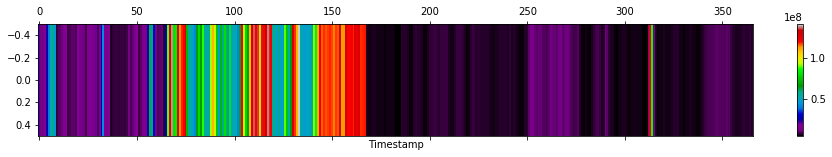

In [8]:
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')

df = pd.DataFrame(ts).T

plt.matshow(df, interpolation=None, aspect='auto', cmap=plt.cm.nipy_spectral) 
plt.xlabel('Timestamp')
plt.colorbar()
plt.show()

We can see very high values in the first half of the year. Let's get a more detailed view with a line plot

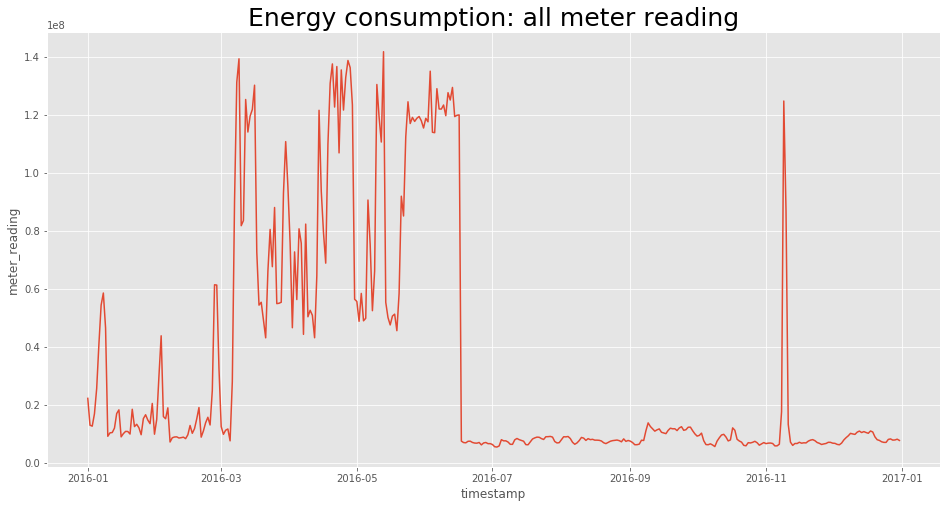

In [50]:
plt.style.use('ggplot')
plt.figure(figsize=(16,8))
plt.title('Energy consumption: all meter reading', fontsize = 25)
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts)
plt.show()
plt.close();

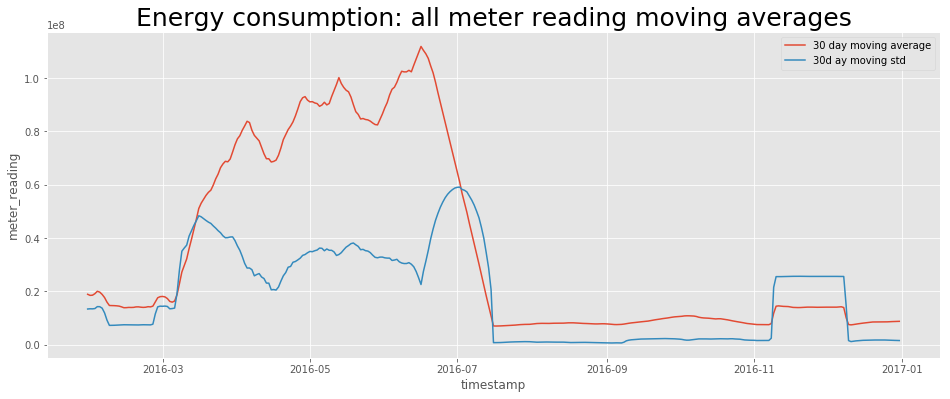

In [51]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=30,center=False).mean(),label='30 day moving average');
plt.plot(ts.rolling(window=30,center=False).std(),label='30d ay moving std');
plt.title('Energy consumption: all meter reading moving averages', fontsize = 25)
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.legend()
plt.show()
plt.close();

First plot shows the noisiness of the data at the daily level. The energy swings are pretty wild. The second plot shows a more sedated behavior due to the smoothing provided by the moving averages. Both readings show a peculiar behavior: energy consumption peaks sometimes between March and August, and in a much lesser fashion, in December, only to drop around December 20 and stay low into January. So what the data is telling us is that in the coldest months of the year the energy consumption is at the same level as in August. Of course, we're assuming a northern hemisphere, temperate latitudes behavior.

## Time series decomposition

A series is thought to be an aggregate or combination of four components:

 **Level**: The average value in the series.

 **Trend**: The increasing or decreasing value in the series.

 **Seasonality**: The repeating short-term cycle in the series.

 **Noise**: The random variation in the series.

All series have a **level** and **noise**. The **trend** and **seasonality** components are optional. It is helpful to think of the components as combining either **additively** or **multiplicatively**

An additive model suggests that the 4 components above are added together 

A multiplicative model suggests that the 4 components above are multiplied together 

This is a useful abstraction. Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem. It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and speciﬁcally in terms of how to best capture each of these components in a given model



Let's decompose our time series and see what we can glean from the meter reading data

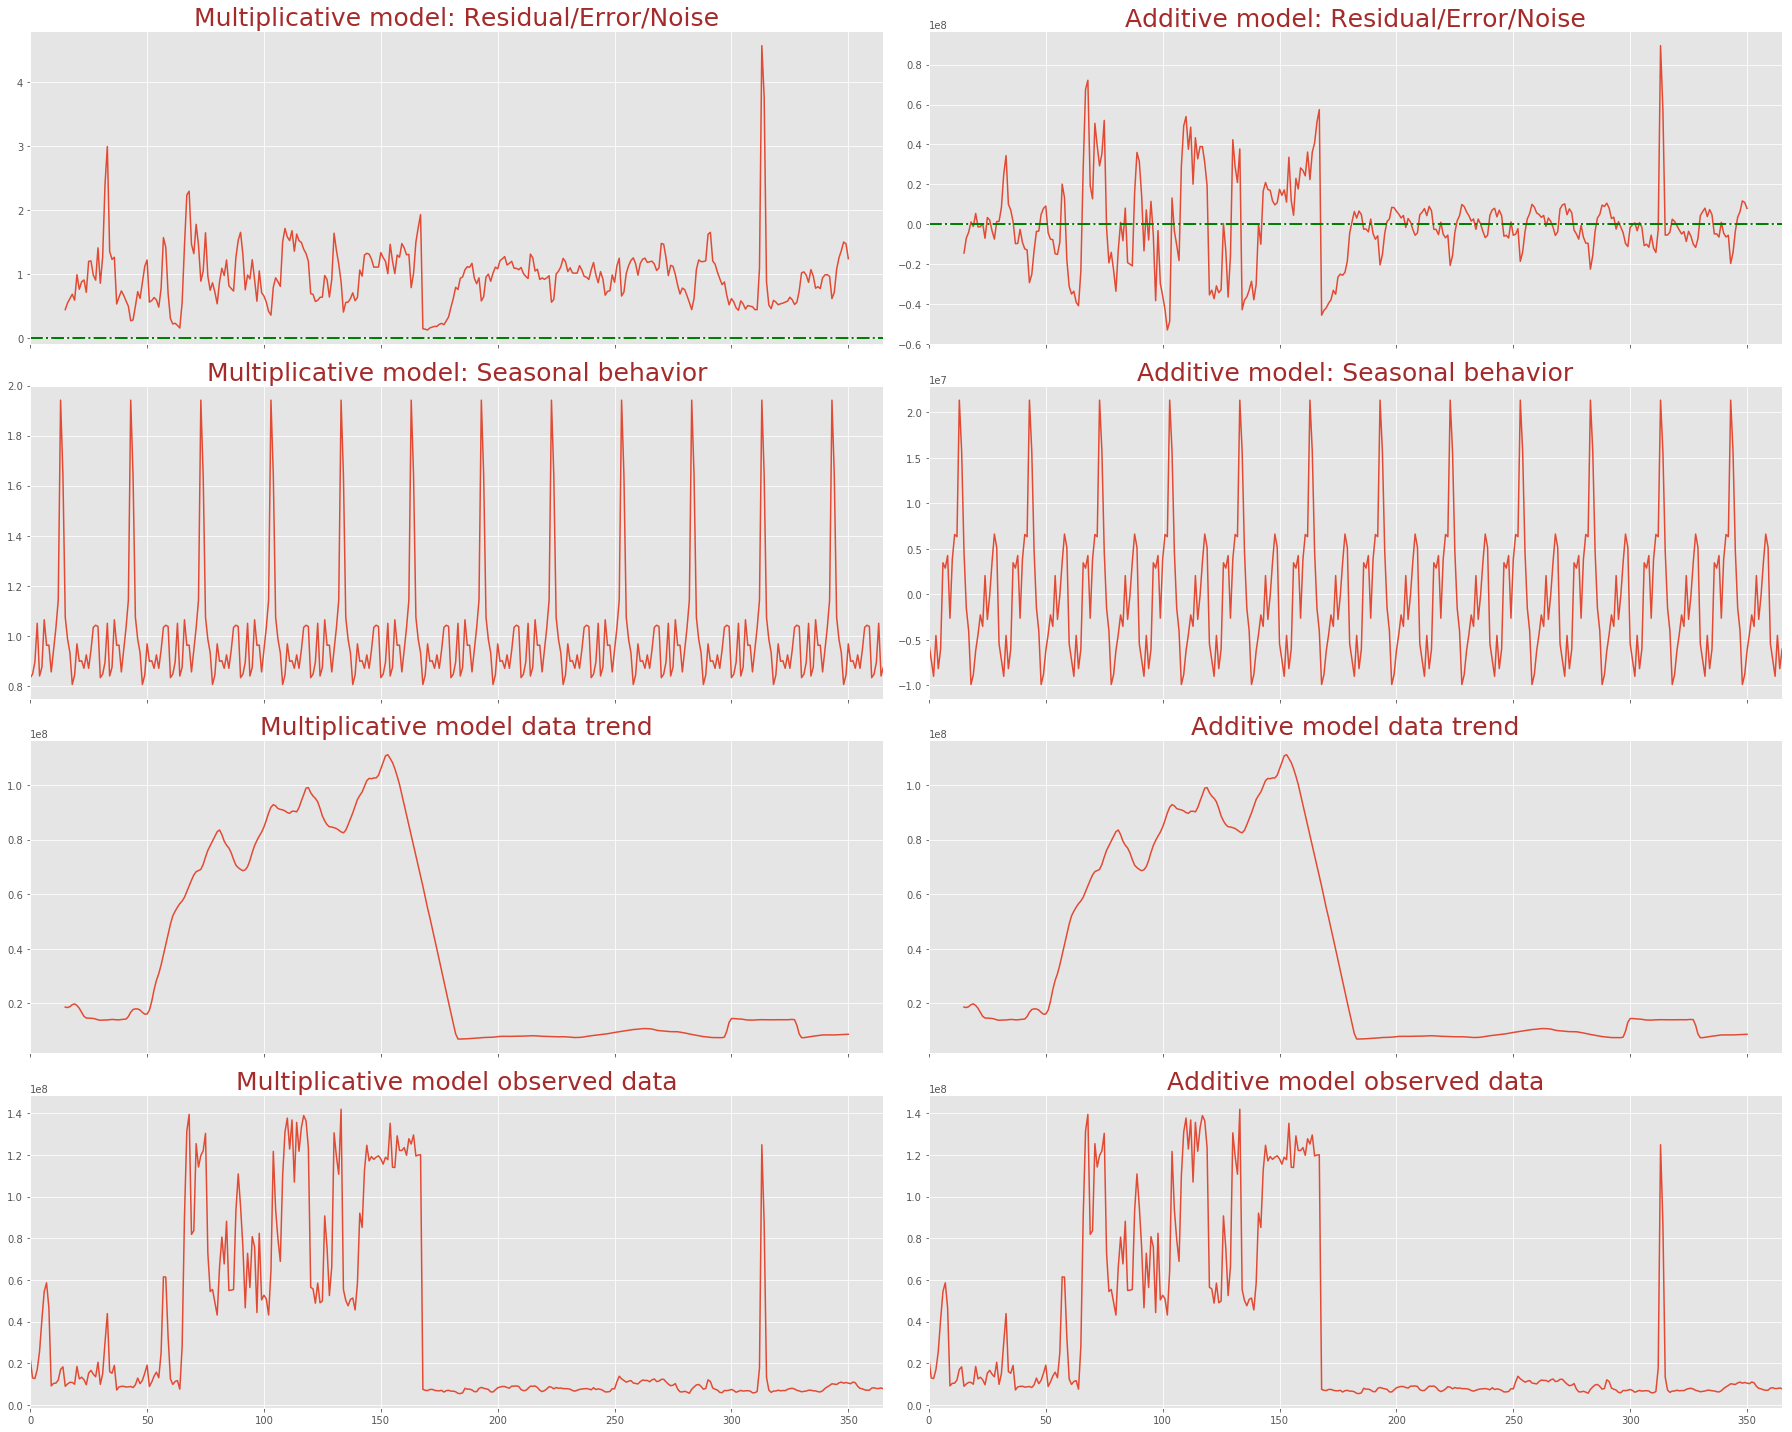

In [11]:
import statsmodels.api as sm


# Multiplicative model
s1 = sm.tsa.seasonal_decompose(ts.values,freq=30,model="multiplicative")

# Additive model
s2 = sm.tsa.seasonal_decompose(ts.values,freq=30,model="additive")

plt.style.use('ggplot')
def plot_seasonal(res, axes, model_type):
    pd.DataFrame(res.observed).plot(ax=axes[3], legend = False)
    axes[3].set_title(model_type + ' ' + 'observed data', fontsize=25, color = 'brown')
    
    pd.DataFrame(res.trend).plot(ax=axes[2], legend = False)
    axes[2].set_title(model_type + ' ' + 'data trend', fontsize=25, color = 'brown')
    
    pd.DataFrame(res.seasonal).plot(ax=axes[1], legend = False)
    axes[1].set_title(model_type + ': ' + 'Seasonal behavior', fontsize=25, color = 'brown')
                 
    pd.DataFrame(res.resid).plot(ax=axes[0], legend = False)
    axes[0].set_title(model_type + ': ' + 'Residual/Error/Noise', fontsize=25, color = 'brown')
    axes[0].axhline(0, linestyle = '-.', lw = 2, color = 'g')
                 
fig, axes = plt.subplots(4,2, sharex=True, figsize=(25,20))
                 
plot_seasonal(s1, axes[:,0], 'Multiplicative model')
plot_seasonal(s2, axes[:,1], 'Additive model')

plt.tight_layout()
plt.show()
plt.close();

There's a couple of interesting things revealed by plots above. Let's look at the **noise** information first. Noise is supposed to be random i.e. have a Gaussian distribution with a mean of zero (if this is ***not*** the case, it means that there's still **some signal** in the noise and the noise is not really just noise at all). Gaussian means it has to be distributed around the 0 line (green in the first plots above). The multiplicative model has the noise above the zero line for the entire range. This bias in the noise data rules out the teoretical categorization of our time series as being multiplicative. As for the additive model, the noise meanders around the zero mean but it seems to have a pattern. 

There's still **some signal** in this noise.

# Noise autocorrelation

A way to confirm the presence of a signal in the noise is to plot a correlogram of the noise

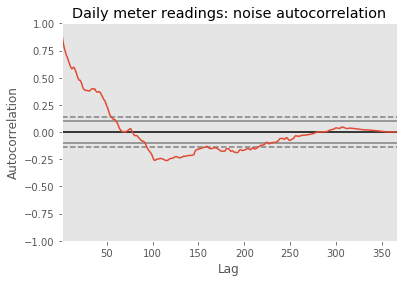

In [12]:
from pandas.plotting import autocorrelation_plot

noise = ts - ts.mean()

autocorrelation_plot(noise) 
plt.title('Daily meter readings: noise autocorrelation')
plt.show()

Pure noise stays between the 90% or 95% significance levels (the lines parallel with the y axis). Ours doesn't. 

There's some signal in the noise. What is the signal?

Text(0.5, 1.0, 'Meter readings, mean vs max values, all meters aggregated')

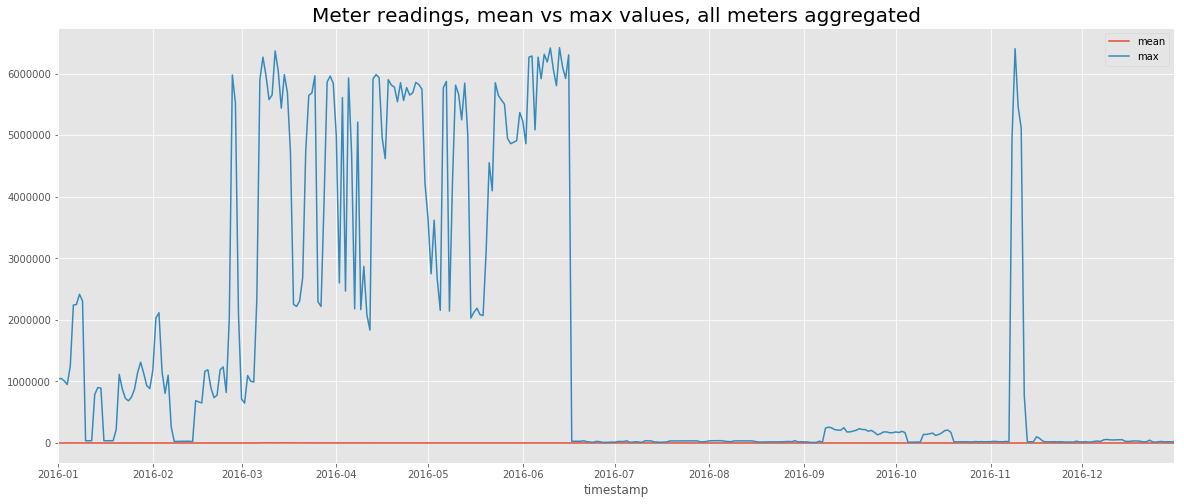

In [13]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_max_time = train_df.groupby('timestamp').meter_reading.max()
y_mean_time.plot(figsize=(20, 8), label='mean')
y_max_time.plot(figsize=(20, 8), label='max')
plt.legend()
plt.title('Meter readings, mean vs max values, all meters aggregated', fontsize=20)

The mean values are completely dwarfed by the max value. The max value surpasses 6,000,000 units. What are the mean values?

Text(0.5, 1.0, 'Meter readings, mean values, all meters aggregated')

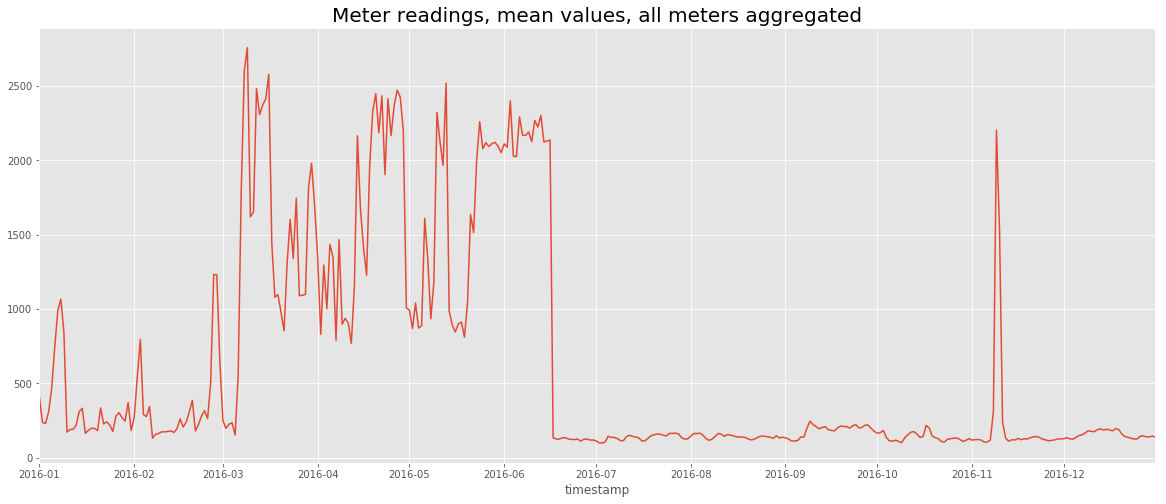

In [14]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8), label='mean')
plt.title('Meter readings, mean values, all meters aggregated', fontsize=20)

The maximum mean values are around 2,500 units. The max values (6,000,000) are more than three orders of magnitude larger than the mean values. The shape of the mean looks identical to the shape of the max readings. This means the mean is completely dominated by the one mega outlier. This is the meaning of the signal we were looking for: there is an outlier, maybe more, making the data unbalanced.

## Identifying the outliers

In [8]:
outlier_bld_id = []

daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]

# electricity ourliers
print('\n\nNumber of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 6 buildings:\n')

outlier_electricity = daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].unique()

outlier_electricity 

for i in outlier_electricity:
    outlier_bld_id.append(i)


# chilled water
print('\n\nNumber of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 10 buildings:\n')
outlier_chilled_w = daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].unique()
print(outlier_chilled_w)
for i in outlier_chilled_w:
    outlier_bld_id.append(i)

# steam
print('\n\nNumber of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 4 buildings:\n')
outlier_steam = daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].unique()
print(outlier_steam)
for i in outlier_steam:
    outlier_bld_id.append(i)

#Hotwater
print('\n\nNumber of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 7 buildings:\n')
outlier_hotwater = daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].unique()
print(outlier_hotwater)
for i in outlier_hotwater:
    outlier_bld_id.append(i)

print(outlier_bld_id)



Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 6 buildings:



Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 10 buildings:

[1289 1258 1284   29   76 1156   60  778 1088   50]


Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 4 buildings:

[1099 1197 1168 1148]


Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    229


# Visualize the energy consumption by meter type and building id

### Drop the outliers

In [9]:
# drop outliers
s1 = train_df.shape[0]

for i in outlier_bld_id:
    train_df = train_df[train_df['building_id'] != i]

dropped_rows = s1 - train_df.shape[0]
print('Dropped rows due to outliers:',dropped_rows)

Dropped rows due to outliers: 589640


# Visualizing data after outlier removal

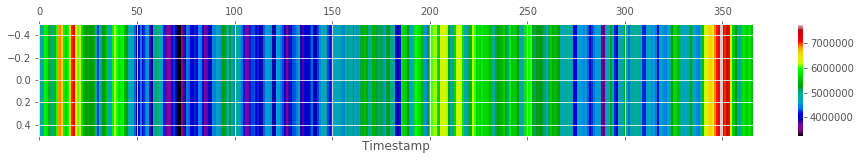

In [71]:
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')

df = pd.DataFrame(ts).T

plt.matshow(df, interpolation=None, aspect='auto', cmap=plt.cm.nipy_spectral) 
plt.xlabel('Timestamp')
plt.colorbar()
plt.show()

How the situation changed! We have the exact opposite of the previous situation, before the outlier removal.

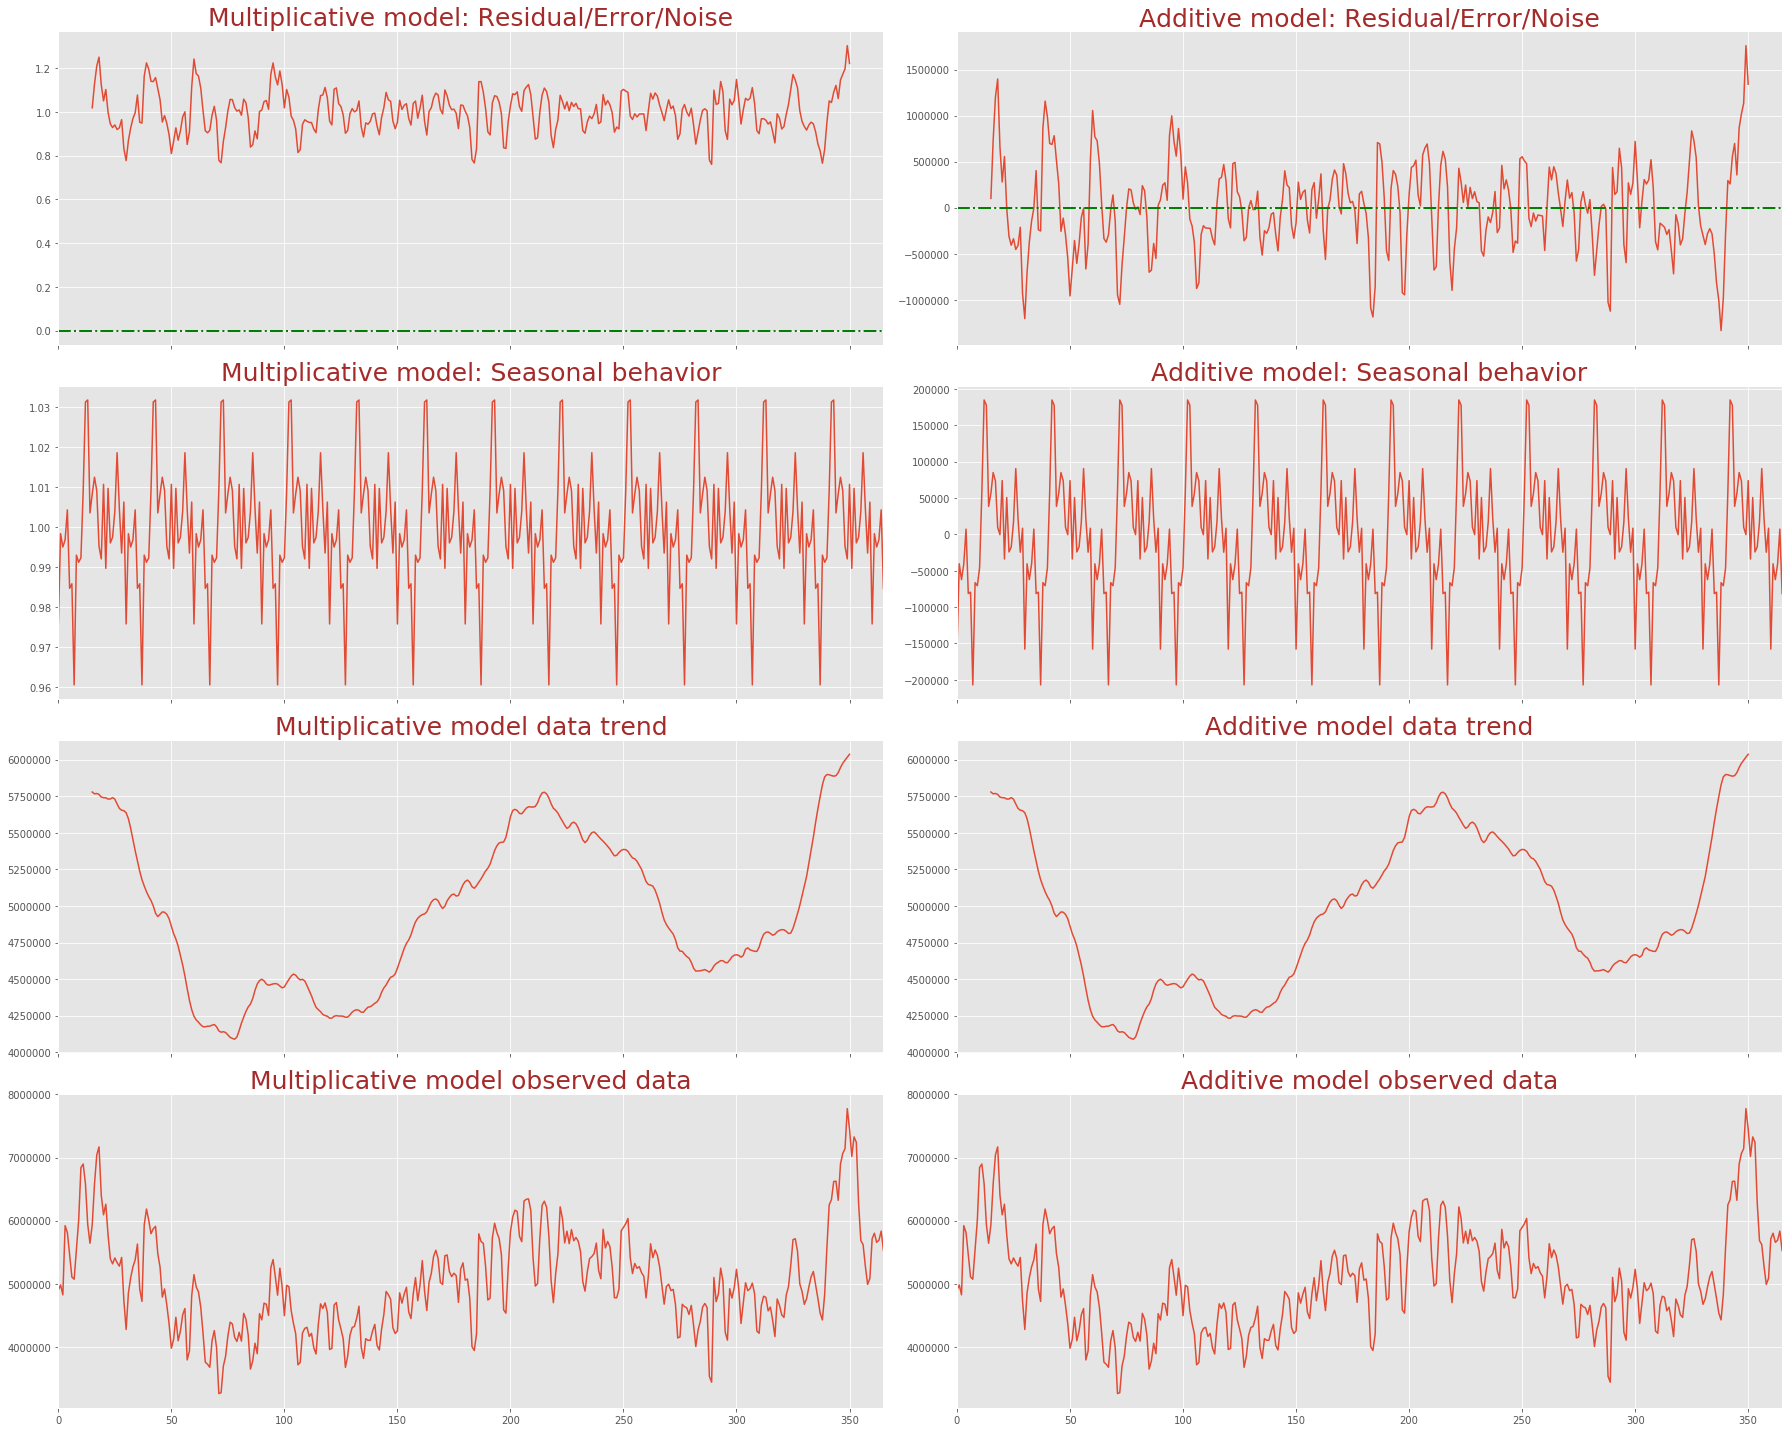

In [73]:
# Multiplicative model
s1 = sm.tsa.seasonal_decompose(ts.values,freq=30,model="multiplicative")

# Additive model
s2 = sm.tsa.seasonal_decompose(ts.values,freq=30,model="additive")

plt.style.use('ggplot')
def plot_seasonal(res, axes, model_type):
    pd.DataFrame(res.observed).plot(ax=axes[3], legend = False)
    axes[3].set_title(model_type + ' ' + 'observed data', fontsize=25, color = 'brown')
    
    pd.DataFrame(res.trend).plot(ax=axes[2], legend = False)
    axes[2].set_title(model_type + ' ' + 'data trend', fontsize=25, color = 'brown')
    
    pd.DataFrame(res.seasonal).plot(ax=axes[1], legend = False)
    axes[1].set_title(model_type + ': ' + 'Seasonal behavior', fontsize=25, color = 'brown')
                 
    pd.DataFrame(res.resid).plot(ax=axes[0], legend = False)
    axes[0].set_title(model_type + ': ' + 'Residual/Error/Noise', fontsize=25, color = 'brown')
    axes[0].axhline(0, linestyle = '-.', lw = 2, color = 'g')
                 
fig, axes = plt.subplots(4,2, sharex=True, figsize=(25,20))
                 
plot_seasonal(s1, axes[:,0], 'Multiplicative model')
plot_seasonal(s2, axes[:,1], 'Additive model')

plt.tight_layout()
plt.show()
plt.close();

How the situation changed! We have the exact opposite of the previous situation, before the outlier removal.

Let's get a more detailed picture of energy consumption by slicing the meter readings by meter type and by primary use

### Energy readings by meter type

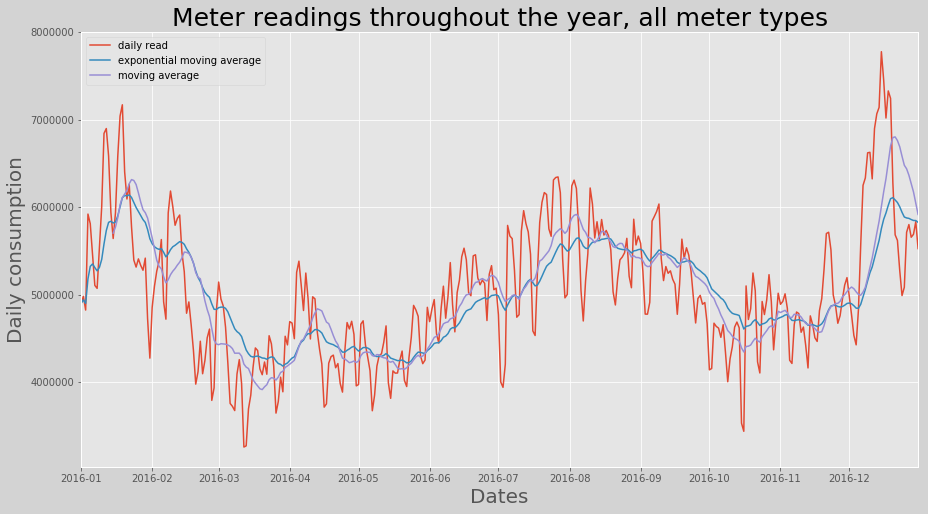

In [59]:
# meter readings regardless of energy type
daily_meter_reading = train_df.groupby(['timestamp'])['meter_reading'].sum()
exp_15 = daily_meter_reading.ewm(com=15).mean()
rolling_15 = daily_meter_reading.rolling(window=15).mean()

plt.figure(figsize=(15,8),facecolor='lightgrey')

plt.plot(daily_meter_reading, label='daily read')
exp_15.plot(label='exponential moving average')
plt.plot(rolling_15, label='moving average')

plt.title('Meter readings throughout the year, all meter types',  fontsize=25)
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.legend()
plt.show()
plt.close()

Now we can see patterns consistent with the northern hemisphere: high consumption during winter and at the peak of the summer. The signal was retrieved from the noise

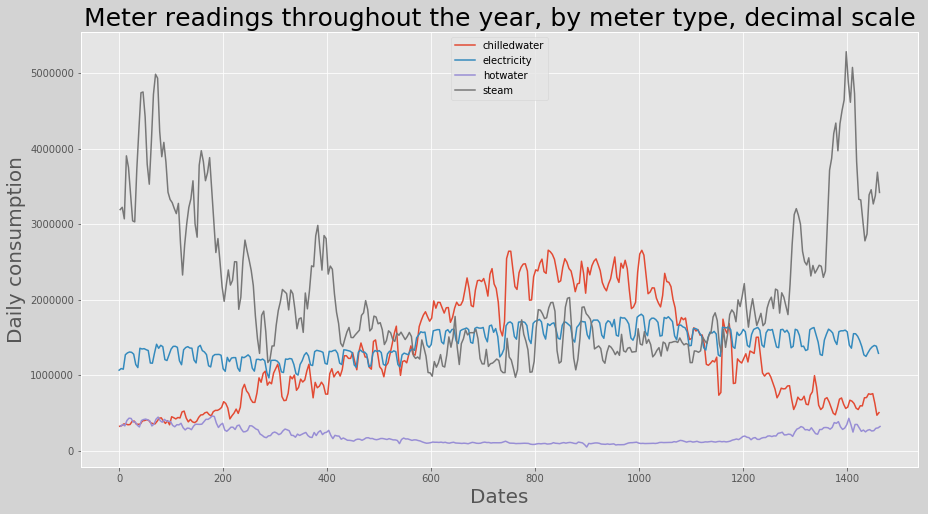

In [61]:
# meter types
meter_type = np.unique(train_df['meter'].values)

# meter readings, all energy types
daily_meter_alltype = train_df.groupby(['timestamp','meter'])['meter_reading'].sum()
daily_meter_alltype = daily_meter_alltype.reset_index()

# store readings by meter type
key=list(meter_type)
val=list(np.zeros(len(meter_type)))
meter_type_yearly = {k:v for k,v in zip(key, val)}

# meter readings by energy type
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    yearly = []
    daily_readings = daily_meter_alltype[daily_meter_alltype['meter']==i]['meter_reading']
    yearly.append(daily_readings)
    plt.plot(daily_readings, label=i)
    #plt.plot_date(dates, daily_readings, alpha=.7, label=i)
    meter_type_yearly[i] += np.array(yearly).sum()
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by meter type, decimal scale',  fontsize=25)

plt.show()

#### We see different patterns for different meter types:

       - chilled water peaks in the heat of the summer
       - steam plummets during the summer months
       - electricity looks steady throughout
       - hotwater dips during the summer months and peaks in the cold season
       
 Now data starts to make sense

# Logarithmic scale

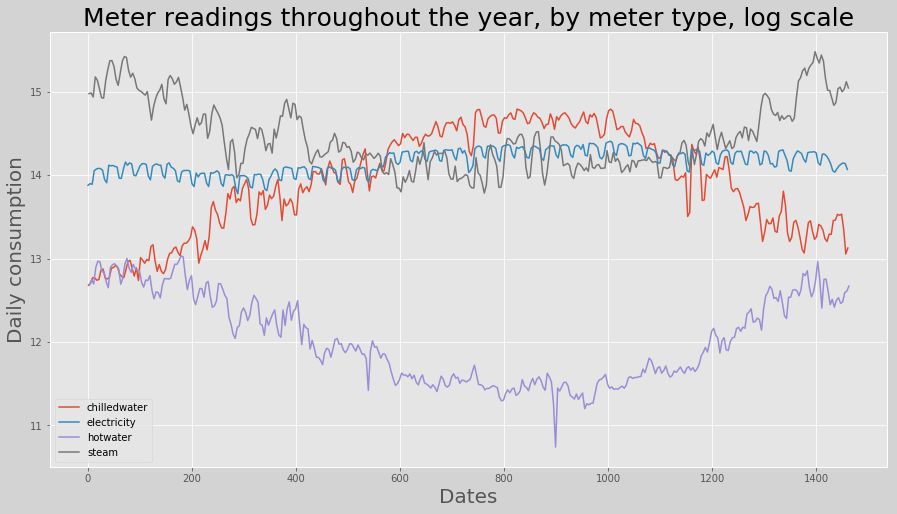

In [68]:
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    daily_meter_type = daily_meter_alltype[daily_meter_alltype['meter']==i]['meter_reading']
    #plt.plot_date(dates, np.log1p(daily_meter_type), alpha=.7, label=i)
    plt.plot(np.log1p(daily_meter_type), label=i)
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by meter type, log scale',  fontsize=25)

plt.show()
plt.close()

### Summarize the energy readings by meter type

In [78]:
# dict to dataframe
meter_type_yearly_df = pd.DataFrame.from_dict(meter_type_yearly, orient='index', columns=['meter_type_yearly'])
m_type_yearly = meter_type_yearly_df.sort_values('meter_type_yearly', ascending = False)
print(m_type_yearly)

              meter_type_yearly
steam               763738368.0
electricity         524014688.0
chilledwater        482820448.0
hotwater             70276160.0


### Energy readings by primary use

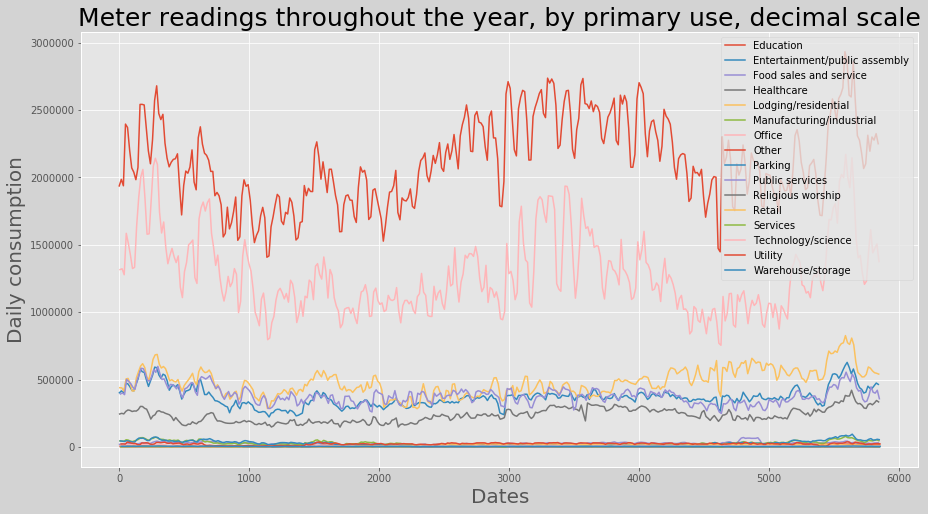

In [69]:
primary_use_type = np.unique(train_df['primary_use'].values)

# meter readings, all use types
daily_use_all = train_df.groupby(['timestamp','primary_use'])['meter_reading'].sum()
daily_use_all = daily_use_all.reset_index()

# store the meter readings by primary use in dict
ky=list(primary_use_type)
vl=list(np.zeros(len(list(primary_use_type))))
primary_use_yearly = {k:v for k,v in zip(ky,vl)}

# meter readings by primary use type, decimal scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily = []
    daily_use_type = daily_use_all[daily_use_all['primary_use']==i]['meter_reading']
    daily.append(daily_use_type)
    plt.plot( daily_use_type,  label=i)
    primary_use_yearly[i] += np.array(daily).sum()
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by primary use, decimal scale',  fontsize=25)
plt.show()
plt.close()

The picture is becoming crowded but the main message is we see at least three or four clusterings of patterns of energy usage. We can use this information in our prediction architecture

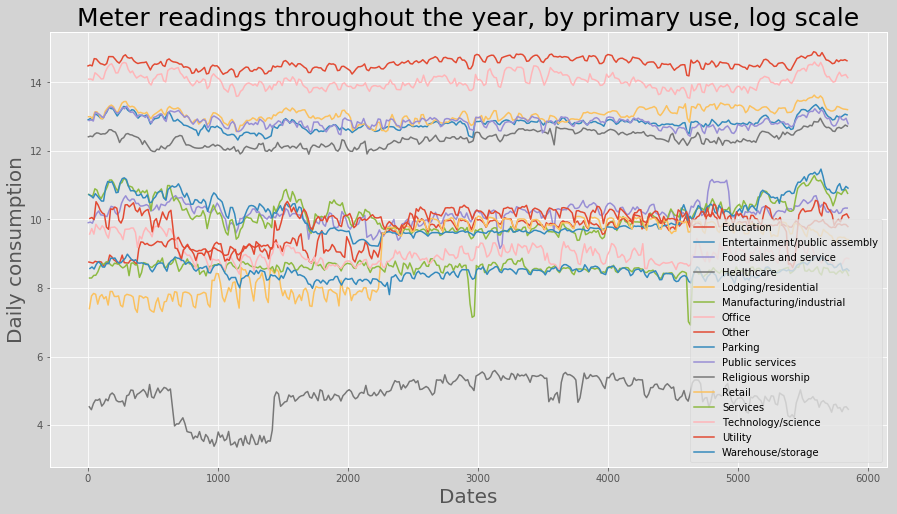

In [70]:
# meter readings by primary use type, log scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily_use_type = daily_use_all[daily_use_all['primary_use']==i]['meter_reading']
    plt.plot(np.log1p(daily_use_type), label=i)
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by primary use, log scale',  fontsize=25)
plt.show()
plt.close()

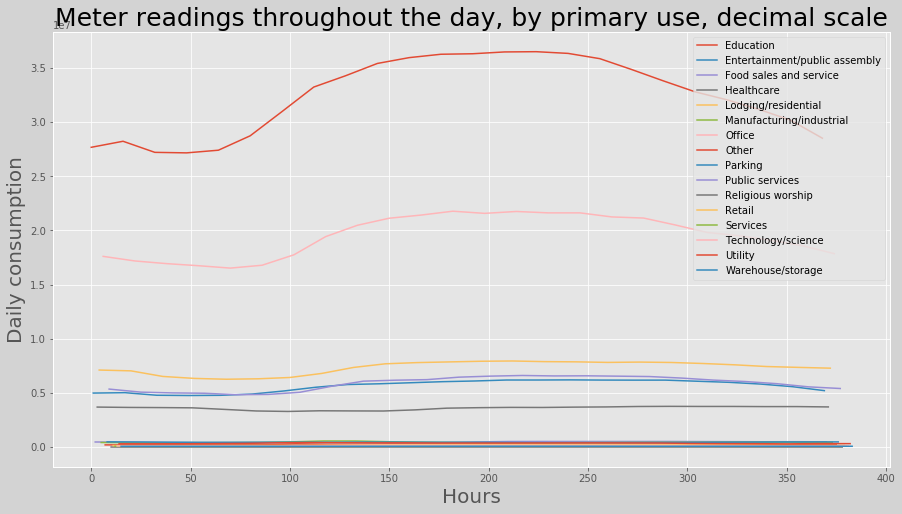

In [14]:
# HOURLY DATA by primary use

plt.style.use('ggplot')

primary_use_type = np.unique(train_df['primary_use'].values)

# meter readings, all use types
daily_use_hour = train_df.groupby(['hour','primary_use'])['meter_reading'].sum()
daily_use_hour = daily_use_hour.reset_index()

# store the meter readings by primary use in dict
#ky=list(primary_use_type)
#vl=list(np.zeros(len(list(primary_use_type))))
#primary_use_yearly = {k:v for k,v in zip(ky,vl)}

# meter readings by primary use type, decimal scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily = []
    daily_use_type = daily_use_hour[daily_use_hour['primary_use']==i]['meter_reading']
    #daily.append(daily_use_type)
    plt.plot( daily_use_type,  label=i)
    #primary_use_yearly[i] += np.array(daily).sum()
plt.legend()
plt.xlabel('Hours', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the day, by primary use, decimal scale',  fontsize=25)
plt.show()
plt.close()

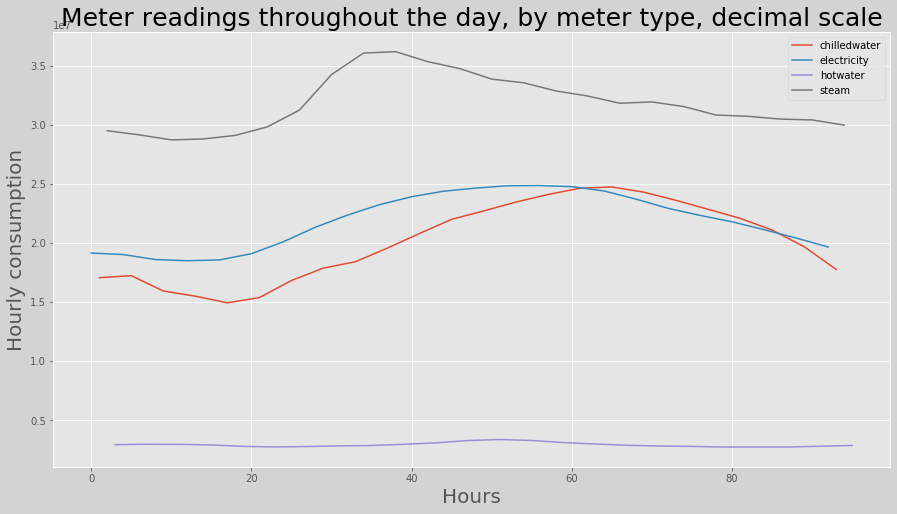

In [15]:
# HOURLY DATA by meter type
# meter types

plt.style.use('ggplot')
meter_type = np.unique(train_df['meter'].values)

# meter readings, all energy types
daily_meter_alltype_hourly = train_df.groupby(['hour','meter'])['meter_reading'].sum()
daily_meter_alltype_hourly = daily_meter_alltype_hourly.reset_index()

# store readings by meter type
#key=list(meter_type)
#val=list(np.zeros(len(meter_type)))
#meter_type_yearly = {k:v for k,v in zip(key, val)}

# meter readings by energy type
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    yearly = []
    daily_readings = daily_meter_alltype_hourly[daily_meter_alltype_hourly['meter']==i]['meter_reading']
    #yearly.append(daily_readings)
    plt.plot(daily_readings, label=i)
    #plt.plot_date(dates, daily_readings, alpha=.7, label=i)
    #meter_type_yearly[i] += np.array(yearly).sum()
    
plt.legend()
plt.xlabel('Hours', fontsize=20)
plt.ylabel('Hourly consumption', fontsize=20)
plt.title('Meter readings throughout the day, by meter type, decimal scale',  fontsize=25)

plt.show()

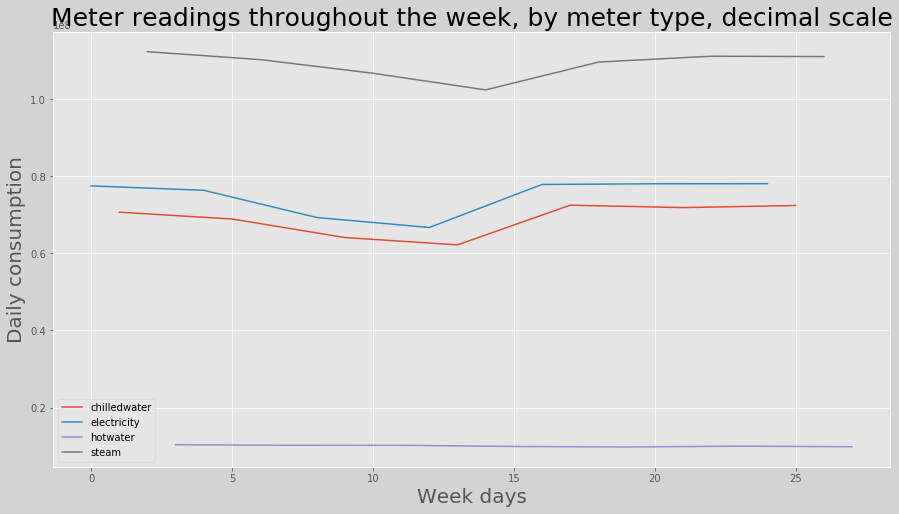

In [16]:
# WEEKLY DATA by meter type
# meter types

plt.style.use('ggplot')
meter_type = np.unique(train_df['meter'].values)

# meter readings, all energy types
daily_meter_alltype_dayname = train_df.groupby(['week_day_name','meter'])['meter_reading'].sum()
daily_meter_alltype_dayname = daily_meter_alltype_dayname.reset_index()

# store readings by meter type
#key=list(meter_type)
#val=list(np.zeros(len(meter_type)))
#meter_type_yearly = {k:v for k,v in zip(key, val)}

# meter readings by energy type
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    yearly = []
    daily_readings = daily_meter_alltype_dayname[daily_meter_alltype_dayname['meter']==i]['meter_reading']
    #yearly.append(daily_readings)
    plt.plot(daily_readings, label=i)
    #plt.plot_date(dates, daily_readings, alpha=.7, label=i)
    #meter_type_yearly[i] += np.array(yearly).sum()
    
plt.legend()
plt.xlabel('Week days', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the week, by meter type, decimal scale',  fontsize=25)

plt.show()

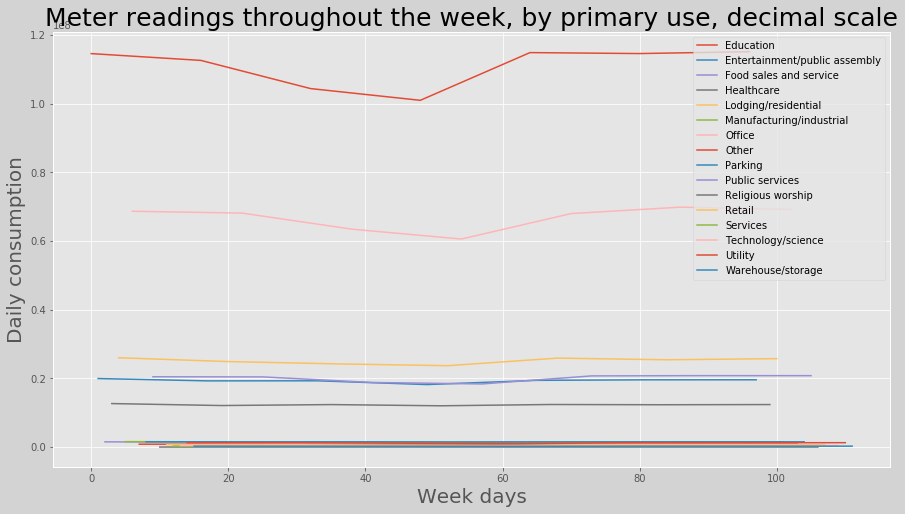

In [17]:
# WEEKLY DATA by primary use

plt.style.use('ggplot')

primary_use_type = np.unique(train_df['primary_use'].values)

# meter readings, all use types
daily_use_dayname = train_df.groupby(['week_day_name','primary_use'])['meter_reading'].sum()
daily_use_dayname = daily_use_dayname.reset_index()

# store the meter readings by primary use in dict
#ky=list(primary_use_type)
#vl=list(np.zeros(len(list(primary_use_type))))
#primary_use_yearly = {k:v for k,v in zip(ky,vl)}

# meter readings by primary use type, decimal scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily = []
    daily_use_type = daily_use_dayname[daily_use_dayname['primary_use']==i]['meter_reading']
    #daily.append(daily_use_type)
    plt.plot( daily_use_type,  label=i)
    #primary_use_yearly[i] += np.array(daily).sum()
plt.legend()
plt.xlabel('Week days', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the week, by primary use, decimal scale',  fontsize=25)
plt.show()
plt.close()

Let's see a more legible breakdown of energy usage by primary use

### Energy readings by primary use

In [22]:
# dict to dataframe
primary_use_yearly_df = pd.DataFrame.from_dict(primary_use_yearly, orient='index', columns=['primary_use_yearly'])
primary_use = primary_use_yearly_df.sort_values('primary_use_yearly',ascending=False)
print(primary_use)

                               primary_use_yearly
Education                            7.775697e+08
Office                               4.681588e+08
Lodging/residential                  1.759697e+08
Public services                      1.404797e+08
Entertainment/public assembly        1.353895e+08
Healthcare                           8.627430e+07
Parking                              1.061439e+07
Manufacturing/industrial             1.053430e+07
Food sales and service               1.019606e+07
Utility                              8.446365e+06
Other                                5.680922e+06
Retail                               4.615582e+06
Technology/science                   3.144489e+06
Services                             1.942549e+06
Warehouse/storage                    1.782348e+06
Religious worship                    5.098995e+04


# Examine the missing values

In [23]:
# checking missing data for train_df
total_train = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total_train, percent], axis=1, keys=['Total', 'Percent'])
print('\nMissing train data:\n',missing_train_data.head(4))

# checking missing data for train_df
total_test = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total_test, percent], axis=1, keys=['Total', 'Percent'])
print('\nMissing test data:\n',missing_test_data.head(4))


Missing train data:
                     Total    Percent
floor_count      16241623  82.753706
windchill          140588   0.716319
wind_kmh           139075   0.708610
air_temperature     93130   0.474512

Missing test data:
                     Total    Percent
floor_count      34444320  82.605042
windchill          313413   0.751633
wind_kmh           302089   0.724476
air_temperature    221901   0.532167
